In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import plotly.express as px
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering


you have to figure out how you can use the work iarantsoa did in this file + change this:<br>
user_style_matrix_scaled<br>
to adapt to what she has

In [2]:
df = pd.read_csv('../../knnData/BA_US_knn_text.csv')

(6331638, 17)
(1829363, 10)
   abv  appearance  taste    rating  style_Altbier  \
0 -0.5         0.0  -0.50 -0.313433            0.0   
1 -0.5        -1.0  -0.75 -1.014925            0.0   
2 -0.5        -2.0  -0.50 -0.955224            0.0   
3 -0.5         0.0   0.00  0.134328            0.0   
4 -0.5         0.0   0.50  0.731343            0.0   

   style_American Adjunct Lager  style_American Amber / Red Ale  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   style_American Amber / Red Lager  style_American Barleywine  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0           

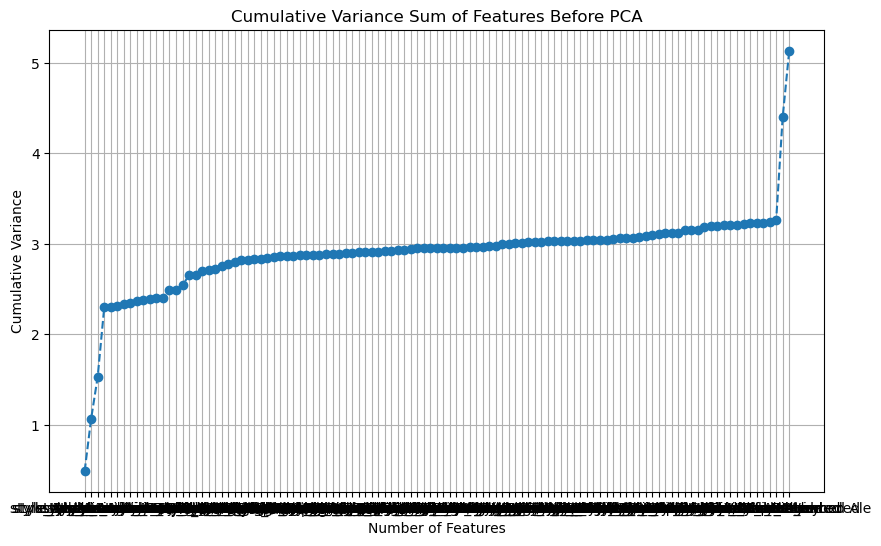

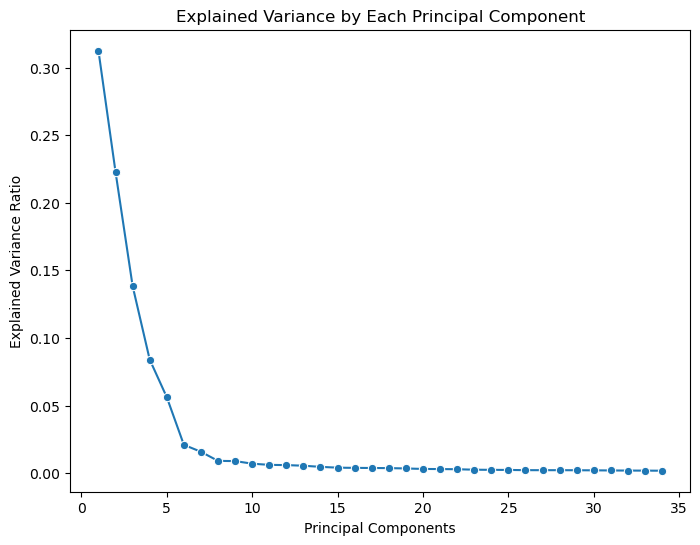

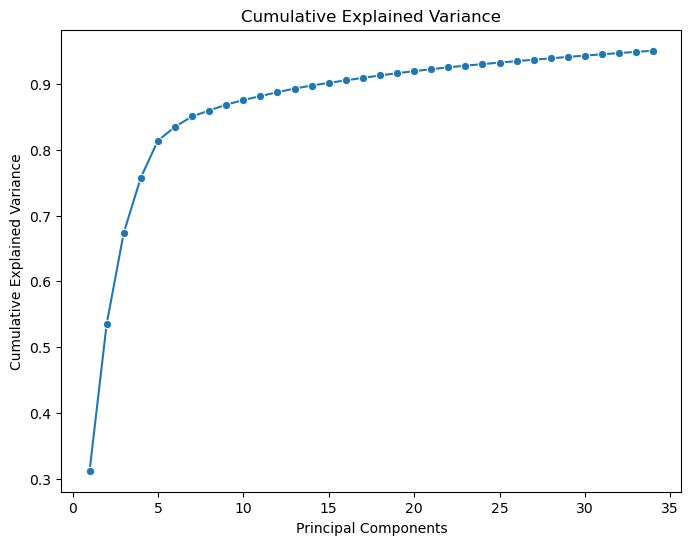

PCA transformed data saved as 'pca_transformed_data.csv'
Shape of the DataFrame: (1829363, 34)


In [3]:
%run param_selec.ipynb

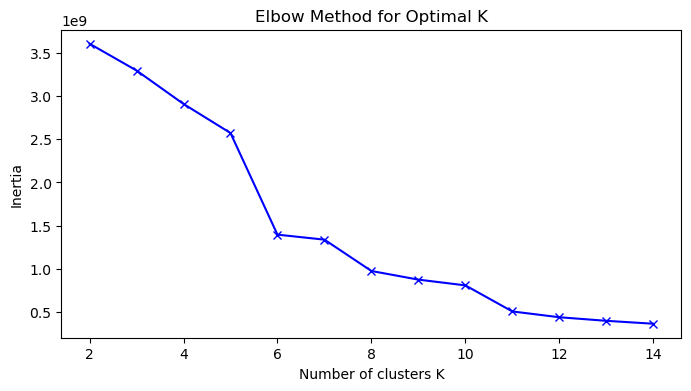

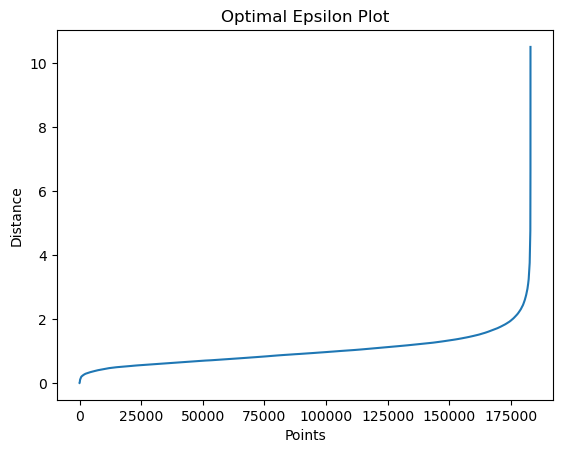

In [4]:
#======================================
#IMPUTATION
#======================================

'''
iter_imputer = IterativeImputer(random_state=42)
X_iter_imputed = pd.DataFrame(iter_imputer.fit_transform(X), columns=X.columns)

print(X_iter_imputed.isnull().sum())
'''
#======================================
#SCALING
#======================================

#scaler = StandardScaler()
scaler = RobustScaler()
#scaler = MinMaxScaler()
#you use this one if the iterative imputer is running
#X_scaled = pd.DataFrame(scaler.fit_transform(X_iter_imputed), columns=X_iter_imputed.columns)
X_scaled = pd.DataFrame(scaler.fit_transform(X_pca_df), columns=X_pca_df.columns)

#======================================
#IMPROVEMENTS ON CLUSTERING
#======================================

#KMEANS
inertia = []
K_range = range(2, 15)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bx-')
plt.xlabel('Number of clusters K')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

#DBSCAN
X_subset = X_scaled.sample(frac=0.1, random_state=42)  # Use 10% of the data

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X_subset)
distances, indices = neighbors_fit.kneighbors(X_subset)

distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.title("Optimal Epsilon Plot")
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

In [5]:

#======================================
#K MEANS CLUSTERING
#======================================
'''
optimal_k = 5
#kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans = KMeans(n_clusters=optimal_k, n_init=50, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels

#silhouette_avg = silhouette_score(X_scaled.drop('cluster', axis=1), cluster_labels)
#print(f'Silhouette Score for K={optimal_k}: {silhouette_avg}')
'''
#======================================
#DBSCAN
#======================================

dbscan = DBSCAN(eps=2.0, min_samples=5, n_jobs=-1)
cluster_labels = dbscan.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels

#======================================
#AGGLOMERATIVE CLUSTERING
#======================================
'''
agglo = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_labels = agglo.fit_predict(X_scaled)
X_scaled['cluster'] = cluster_labels
'''


: 

: 

You are using iterative imputation, which predicts the missing values based on the other features (see param_selec.ipynb => there are ~2.7 million Nan values in certain columns)<br>


You want to look for the "elbow" point in the inertia plot (how close the points are to their center of cluster) => you pick starting that point<br>
=> us around 5 or 6 or 7

In [ ]:
X_scaled

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,cluster
0,-0.346189,-0.146942,-0.685234,-0.273492,0.534917,-0.246150,0.254506,0.093639,-0.266532,-0.367649,...,-0.589257,0.557917,0.531034,0.893527,0.742139,0.458244,-0.515936,-0.760959,-0.992836,2
1,-1.354820,1.855501,-0.031054,-0.089516,-0.323308,0.072194,0.611002,0.206538,-0.251307,-0.136350,...,-0.665407,-0.137852,0.380343,0.619899,0.528079,0.311400,-0.267596,-0.521869,-0.708290,2
2,-1.219042,-0.586325,-0.547099,0.037927,-1.896452,0.192500,0.514411,0.185031,-0.220118,-0.117123,...,-1.054798,-0.330661,0.300205,0.513601,0.346318,0.336668,-0.375703,-0.376182,0.136386,2
3,-0.172341,1.244562,-0.492725,-0.488170,0.015287,-0.276796,0.260339,0.068683,-0.306173,-0.394756,...,-0.474340,0.498244,0.856307,0.892988,0.689989,0.491771,-0.425751,-0.750646,-1.150111,2
4,0.460407,-0.119832,-0.943937,-0.628397,-0.597174,-0.386526,0.049483,-0.007804,-0.319516,-0.509234,...,-0.563164,0.705130,1.062401,0.971819,0.677792,0.590237,-0.547801,-0.789870,-0.970242,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829358,-0.976397,-0.615095,-0.492932,0.503728,0.320415,-0.424567,-0.484958,3.286564,7.693536,2.281015,...,-0.280648,0.141141,-0.827264,-0.666332,-0.027324,0.042926,0.559859,0.108360,0.593787,2
1829359,-0.358000,-0.227511,-0.734607,-0.374050,-0.723419,-0.226675,0.245513,0.067626,-0.381957,-0.433083,...,-0.649332,0.061197,0.768055,1.313154,0.867864,0.776766,-0.647667,-0.939795,-0.819218,2
1829360,-1.696628,-0.636674,-0.392877,0.216081,0.020997,0.115973,0.629483,0.280850,-0.275939,-0.149380,...,-1.205498,-0.242180,0.132508,1.096683,0.851766,0.430057,-0.864517,-0.896837,-0.817069,2
1829361,-2.806287,-1.195477,-0.131715,0.748032,1.559726,0.265359,0.770007,0.263710,-0.245872,-0.008567,...,-0.190866,-0.938782,-1.197408,0.967372,0.873471,0.665239,0.046548,-0.487661,0.374516,2


In [ ]:
'''
for column in X_scaled.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(X_scaled[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()
'''

"\nfor column in X_scaled.columns:\n    plt.figure(figsize=(6, 4))\n    sns.histplot(X_scaled[column], kde=True)\n    plt.title(f'Distribution of {column}')\n    plt.show()\n"

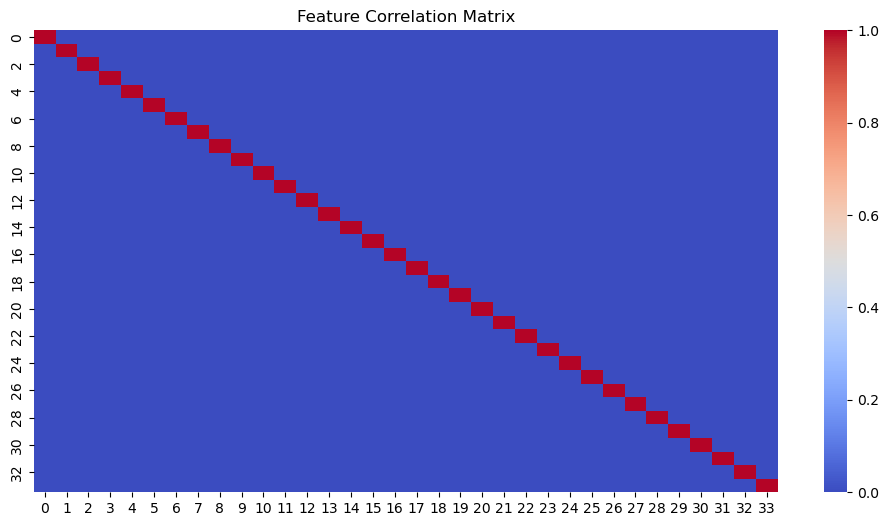

In [ ]:
plt.figure(figsize=(12, 6))
corr_matrix = X_scaled.drop('cluster', axis=1).corr()
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


In [ ]:
df.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,user_id,appearance,aroma,palate,taste,overall,rating,text,avg,user_state,beer_state
0,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,4.4,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,NaN,3.76,North Carolina,Wisconsin
1,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,4.6,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,NaN,3.58,North Carolina,Wisconsin
2,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,5.4,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,NaN,3.48,North Carolina,Wisconsin
3,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,n2185.211743,3.25,3.75,3.50,4.25,4.25,4.00,NaN,4.02,North Carolina,Wisconsin
4,Platinum Coffee Blonde,289324.0,Copper State Brewing Company,49595.0,American Blonde Ale,7.3,angerhaus.1049226,4.00,4.25,3.75,4.00,4.00,4.04,NaN,4.02,Wisconsin,Wisconsin


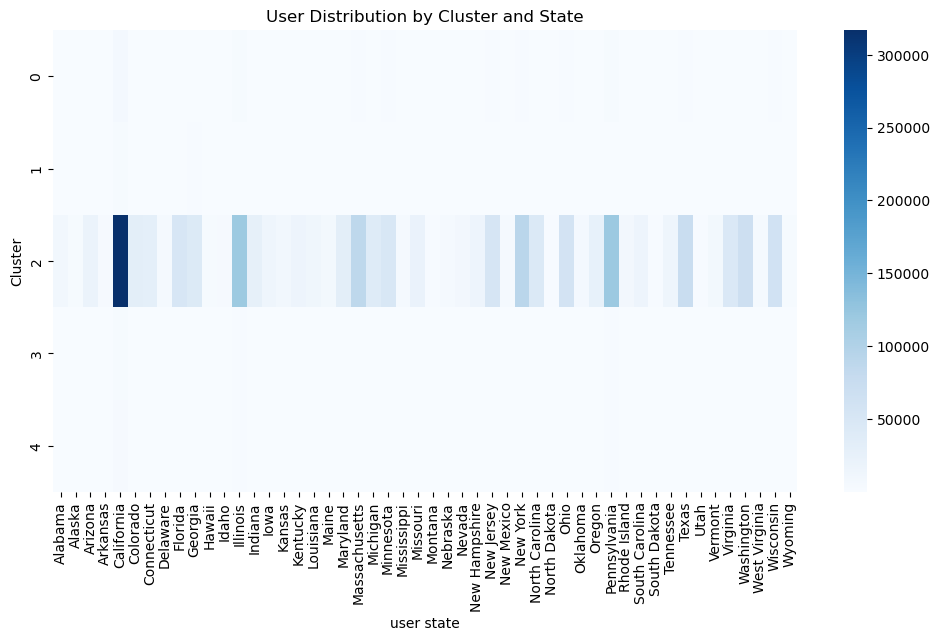

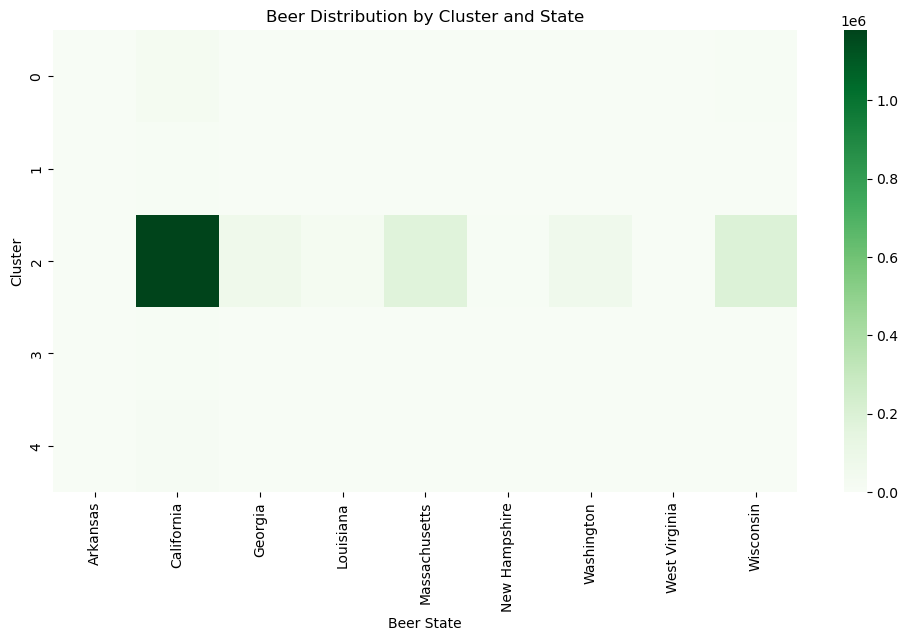

In [ ]:
cluster_labels_df = X_scaled[['cluster']].reset_index(drop=True)
#you can use this (down) when the itreative imputer is able to run
#cluster_labels_df['user_id'] = df['user_id'].values
#cluster_labels_df['beer_id'] = df['beer_id'].values
cluster_labels_df['user_id'] = df.loc[X_pca_df.index, 'user_id'].values
cluster_labels_df['beer_id'] = df.loc[X_pca_df.index, 'beer_id'].values


cluster_labels_df = cluster_labels_df.merge(
    df[['user_id', 'user_state']].drop_duplicates(),
    on='user_id',
    how='left'
)

if 'beer_id' in df.columns:
    cluster_labels_df = cluster_labels_df.merge(
        df[['beer_id', 'beer_state']].drop_duplicates(),
        on='beer_id',
        how='left'
    )

user_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'user_state']).size().unstack(fill_value=0)

if 'beer_state' in cluster_labels_df.columns:
    beer_cluster_state_counts = cluster_labels_df.groupby(['cluster', 'beer_state']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(user_cluster_state_counts, annot=False, fmt='d', cmap='Blues')
plt.title('User Distribution by Cluster and State')
plt.xlabel('user state')
plt.ylabel('Cluster')
plt.show()

if 'beer_state' in cluster_labels_df.columns:
    plt.figure(figsize=(12, 6))
    sns.heatmap(beer_cluster_state_counts, annot=False, fmt='d', cmap='Greens')
    plt.title('Beer Distribution by Cluster and State')
    plt.xlabel('Beer State')
    plt.ylabel('Cluster')
    plt.show()


In [ ]:
user_cluster_state_counts_t = user_cluster_state_counts.T
user_cluster_state_counts_t

cluster,0,1,2,3,4
user_state,,,,,
Alabama,232,127,10818,98,122
Alaska,61,32,2921,34,32
Arizona,521,179,19700,250,254
Arkansas,91,266,4450,52,49
California,7146,3313,316986,3335,3944
Colorado,829,357,32912,438,380
Connecticut,713,351,30480,317,332
Delaware,129,53,5149,49,74
Florida,1219,634,51815,545,620


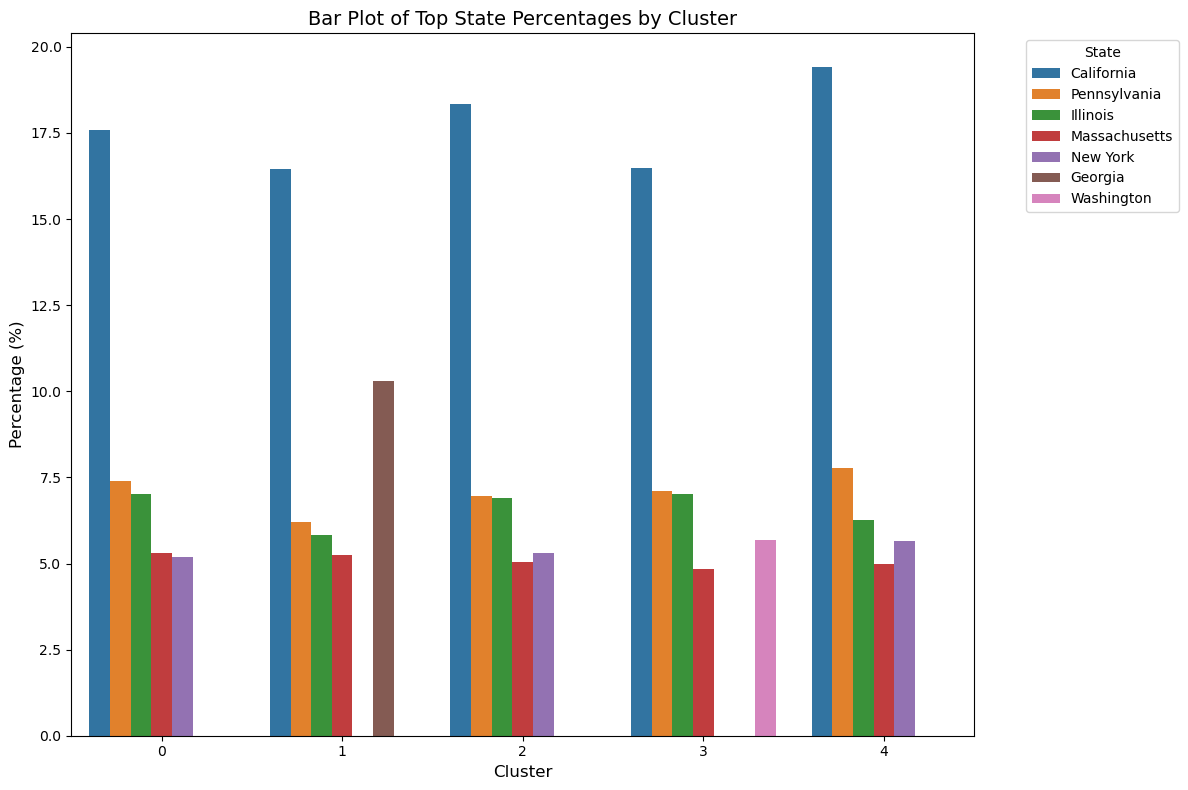

In [ ]:
'''
top_5_data =[]
cluster_totals = user_cluster_state_counts_t.sum(axis=0)
#print(cluster_totals[1])
i = 0
for clusters in user_cluster_state_counts_t.items():
    #print(clusters[0])
    #print(clusters[1].nlargest(5))
    #print(clusters[1].nlargest(5).values)

    top_states = clusters[1].nlargest(5).index
    top_values = clusters[1].nlargest(5).values
    #print(cluster_totals[i])
    top_percentages = (top_values / cluster_totals[i]) * 100
    
    top_5_data.append(pd.DataFrame({'state': top_states, 'percentage': top_percentages, 'cluster': clusters[0]}))
    #print(top_5_data)
    i += 1
top_5_df = pd.concat(top_5_data)
#print(top_5_df)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_df, x='cluster', y='percentage', hue='state', dodge=True)

plt.title("Box Plot of percentage for Each State by Cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()
'''

top_5_data = []
cluster_totals = user_cluster_state_counts_t.sum(axis=0)

for cluster_label, cluster_data in user_cluster_state_counts_t.items():
    # Get the top 5 states and their values for the current cluster
    top_states = cluster_data.nlargest(5).index
    top_values = cluster_data.nlargest(5).values

    # Calculate percentages using the total for the current cluster
    total_in_cluster = cluster_totals[cluster_label]
    top_percentages = (top_values / total_in_cluster) * 100

    # Append the results to the list
    top_5_data.append(pd.DataFrame({
        'state': top_states,
        'percentage': top_percentages,
        'cluster': cluster_label
    }))

# Combine all cluster data into a single DataFrame
top_5_df = pd.concat(top_5_data)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(data=top_5_df, x='cluster', y='percentage', hue='state', dodge=True)

plt.title("Bar Plot of Top State Percentages by Cluster", fontsize=14)
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



In [ ]:
cluster_totals = user_cluster_state_counts_t.sum(axis=0)

for cluster_label, cluster_data in user_cluster_state_counts_t.items():
    # Get the top 5 states for the current cluster
    top_states = cluster_data.nlargest(5).index
    
    # Print the cluster label and its top 5 states
    print(f"Cluster {cluster_label}: {', '.join(top_states)}")


Cluster 0: California, Pennsylvania, Illinois, Massachusetts, New York
Cluster 1: California, Georgia, Pennsylvania, Illinois, Massachusetts
Cluster 2: California, Pennsylvania, Illinois, New York, Massachusetts
Cluster 3: California, Pennsylvania, Illinois, Washington, Massachusetts
Cluster 4: California, Pennsylvania, Illinois, New York, Massachusetts


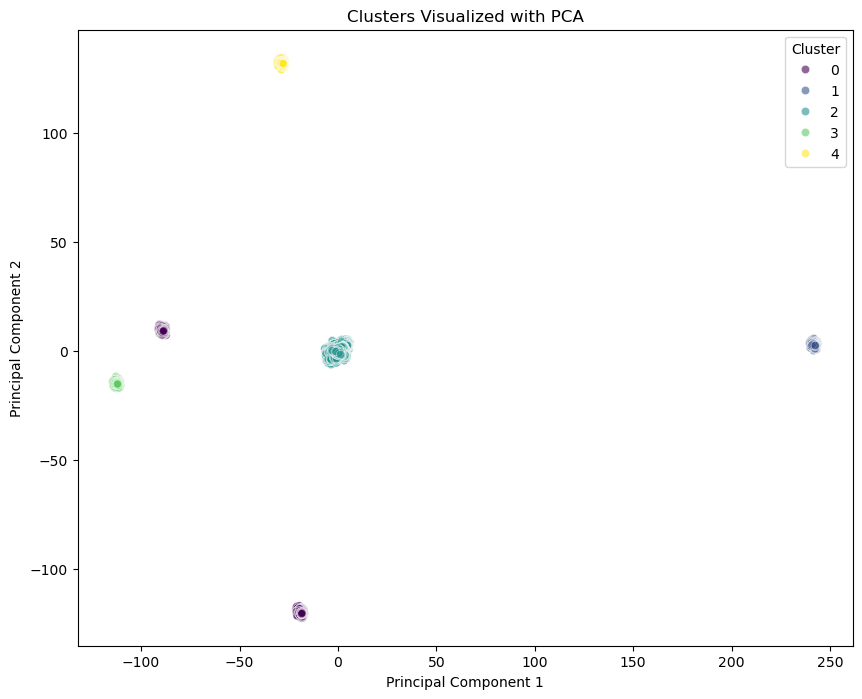

Explained Variance by PC1: 0.40
Explained Variance by PC2: 0.16


In [ ]:
features = X_scaled.drop('cluster', axis=1)

pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(features)

pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='Cluster',
    palette='viridis',
    data=pca_df,
    alpha=0.6
)
plt.title('Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
explained_variance = pca.explained_variance_ratio_
print(f'Explained Variance by PC1: {explained_variance[0]:.2f}')
print(f'Explained Variance by PC2: {explained_variance[1]:.2f}')


In [ ]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X_tsne[:, 0], y=X_tsne[:, 1],
    hue=cluster_labels,
    palette='viridis',
    alpha=0.6
)
plt.title('Clusters Visualized with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Cluster')
plt.show()


NameError: name 'X_tsne' is not defined

<Figure size 1000x800 with 0 Axes>

## Conclusions fromt the clustering trials
the standard scaler is abismal<br>
I think the best scaler is the RobustScaler


In [ ]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

tsne_results = tsne.fit_transform(features)

tsne_df = pd.DataFrame(data=tsne_results, columns=['Dim1', 'Dim2'])
tsne_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dim1', y='Dim2',
    hue='Cluster',
    palette='viridis',
    data=tsne_df,
    alpha=0.6
)
plt.title('Clusters Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(title='Cluster')
plt.show()


/opt/anaconda3/envs/ada/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)

umap_results = umap_reducer.fit_transform(features)

umap_df = pd.DataFrame(data=umap_results, columns=['UMAP1', 'UMAP2'])
umap_df['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Cluster',
    palette='viridis',
    data=umap_df,
    alpha=0.6
)
plt.title('Clusters Visualized with UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.show()


/opt/anaconda3/envs/ada/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


: 

: 

In [ ]:
pca_3d = PCA(n_components=3, random_state=42)
principal_components_3d = pca_3d.fit_transform(features)

pca_3d_df = pd.DataFrame(data=principal_components_3d, columns=['PC1', 'PC2', 'PC3'])
pca_3d_df['Cluster'] = cluster_labels

fig = px.scatter_3d(
    pca_3d_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Cluster',
    title='3D Visualization of Clusters using PCA',
    opacity=0.7
)

fig.show()


you should try bringing up the # of clusters <br>
you should see how you can give more importance to certain features with KNN (maybe brewery is more important?)<br>


In [ ]:

# Initialize DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add labels to DataFrame
X_scaled['DBSCAN_Cluster'] = dbscan_labels

# Visualize with PCA
pca = PCA(n_components=2, random_state=42)
principal_components = pca.fit_transform(X_scaled.drop(['DBSCAN_Cluster'], axis=1))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2',
    hue='DBSCAN_Cluster',
    palette='viridis',
    data=pca_df,
    alpha=0.6
)
plt.title('DBSCAN Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


: 

: 